# Median House Value as a Linear Regression Problem
#### Tensorflow 2

In [29]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15401688136395317774, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14529311268399967483
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17667972804071328674
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2062067185700635560
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# 1. Import libraries

In [30]:
import tensorflow as tf

## Support libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# 2. Load files

In [31]:
ATT_FILE = "/gdrive/My Drive/intelligent systems/MedianHouseValuePreparedCleanAttributes.csv"
LABEL_FILE = "/gdrive/My Drive/intelligent systems/MedianHouseValueContinuousOutput.csv"

TRAIN_RATE=0.8

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)
#n_final_test = n_instances-n_train-n_dev

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

# We cannot employ the final test examples yet, since this is not the final neural model.  

x_train: (16342, 9)
t_train: (16342, 1)
x_dev: (2043, 9)
t_dev: (2043, 1)


Therefore, we consider 16,342 instances to train the regression model (adjusting the weights) and 2,043 cases for development tests to tune the hyperparameters, such as the learning rate or the number of epochs to train.

In [32]:
t_train = t_train.reshape((1,-1))[0]
t_dev = t_dev.reshape((1,-1))[0]
#t_final_test = t_test.reshape((1,-1))[0]

# 3. Initialize variables

In [33]:
INPUTS = x_train.shape[1]
OUTPUTS = 1
NUM_TRAINING_EXAMPLES = round(x_train.shape[0]/1) # training and dev examples can
NUM_DEV_EXAMPLES = round (x_dev.shape[0]/1) # be reduced if needed. 

In [34]:
x_train[:5]

array([[ 0.21713147, -0.69394261,  0.41176471, -0.93926446, -0.88733706,
        -0.90924634, -0.89278079, -0.77585137, -1.        ],
       [-0.69322709,  0.17747078, -0.29411765, -0.91795107, -0.88671633,
        -0.95448303, -0.88949186, -0.59159184,  1.        ],
       [ 0.44820717, -0.95961743,  0.37254902, -0.8306628 , -0.80074488,
        -0.89349477, -0.79575728, -0.5589716 ,  1.        ],
       [ 0.29083665, -0.7088204 , -0.41176471, -0.87629076, -0.85909373,
        -0.94315984, -0.84377569, -0.48705535, -1.        ],
       [-0.40039841,  0.15834219, -0.49019608, -0.8418536 , -0.84574798,
        -0.93413493, -0.82765992, -0.16468738, -0.33333333]])

In [35]:
t_train[:5]

array([-0.61278098, -0.07711308, -0.55876058, -0.33484398, -0.09402023])

In [36]:
x_dev[:5]

array([[ 0.22908367, -0.67906482,  0.45098039, -0.83366397, -0.77343265,
        -0.81524146, -0.76155238, -0.67868029, -1.        ],
       [-0.61752988,  0.10308183,  1.        , -0.94201129, -0.93078833,
        -0.97247681, -0.93257688, -0.37100178,  0.33333333],
       [-0.39043825,  0.16046759, -0.88235294, -0.92929447, -0.90037244,
        -0.90016536, -0.89870087, -0.74136908, -0.33333333],
       [-0.24701195, -0.45377258, -0.33333333, -0.85156926, -0.82774674,
        -0.94030102, -0.81877981, -0.58286093, -1.        ],
       [ 0.22908367, -0.73645058, -0.25490196, -0.90589552, -0.82774674,
        -0.90420135, -0.81746423, -0.86805699,  1.        ]])

In [37]:
t_dev[:5]

array([-0.54020396,  0.17072095, -0.54845135, -0.41525602, -0.43298791])

In [38]:
x_train = tf.cast(x_train,tf.float32)
t_train = tf.cast(t_train,tf.float32)
x_dev = tf.cast(x_dev,tf.float32)
t_dev = tf.cast(t_dev,tf.float32)

## 4. Set hyperparameters 

In [39]:
n_epochs = 1000
learning_rate = 0.1

## 5. Build the neural model: linear regressor

A variable can change its value during the execution phase. <b>W</b> is a matrix of weights (<b>kernel</b>). In this case, a column vector since there is just one output. <b>b</b> is the bias vector, a scalar in this study case. 

In [40]:
W = tf.Variable (tf.random.uniform([INPUTS,1], -1.0,1.0), name="W")
b = tf.Variable (.0, name="bias")

The output function computes the output **y**, called *computed output*, *predicted output*, or *prediction*. The code implemented here calculates $y=Wx+b$. Note that performing $Wx$ or $xW$ depends on the dimension of the vectors (matrices) involved.

In [41]:
def predict (x):
  return tf.add (tf.matmul(x,W), b, name="y")

The loss function is the SSE, defined by $E_p(W)=(y_p-t_p)^2$. The cost function is defined by $MSE=\frac{1}{m} \sum_{i=1}^{m}(y_i-t_i)^2$

In [42]:
def mse (y,t):
  loss = tf.square(y-t)
  return tf.reduce_mean(loss)

The learning method is the gradient descent to minimize the cost MSE, with the previously defined (hyperparameter) learning rate $\alpha$: $\Delta^{(p)}w_{ij}=-\alpha \frac{\partial E^{(p)}(W)}{\partial w_{ij}}$; $w^{(p)}_{ij}(t+1) =w^{(p)}_{ij}(t)-\alpha \frac{\partial E^{(p)}(W)}{\partial w_{ij}}$ 

In [43]:
def training_op(x, t, alpha_lr):
        #First the we compute the error 
        with tf.GradientTape(persistent=True) as g: #persistent=True so parameters can change more than once
            error = mse(predict(x),t)

        #Then, the partial derivative of the error function regarding the weights; i.e., the parameters W and b    
        dE_dW = g.gradient(error, W)
        dE_db = g.gradient(error, b)
        
        #Finally, we multiply the partial derivative by the learning rate and apply the increment 
        W.assign_sub(alpha_lr * dE_dW)
        b.assign_sub(alpha_lr * dE_db)

        return error

# 6. Run the model

The only operation to compute is *trainin_op* to perform a batch-update gradient iteration, i.e., an epoch. Therefore, the function receives the training dataset and the learning rate. 

In [44]:
mse_array = []
for epoch in tqdm(range(n_epochs)): #for each epoch a learning iteration is computed
    loss = training_op (x_train, t_train, learning_rate)
    mse_array.append (loss)


100%|██████████| 1000/1000 [01:38<00:00, 10.13it/s]


# 7. Report results

In [ ]:
final_training_mse = mse(predict(x_train),t_train)
dev_mse = mse(predict(x_dev),t_dev)
predictions = predict(x_dev)

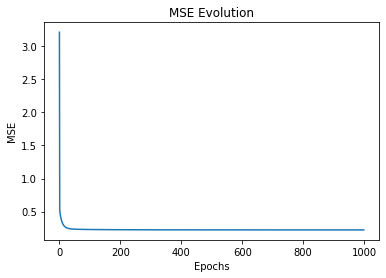

In [ ]:
plt.title("MSE Evolution")
plt.xlabel("Epochs")
plt.ylabel("MSE");
plt.plot(range(n_epochs),mse_array)

<b>The learning process falls into a local optimum</b>. The MSE evolution turns into a flat line from 200 epochs. A linear regression model is trying to solve a non-linear problem. 

In [ ]:
"Final training MSE: " + str(final_training_mse.numpy())

'Final training MSE: 0.22430411'

In [ ]:
"Dev test set MSE: " + str(dev_mse.numpy())

'Dev test set MSE: 0.23850277'

**The final MSE for both the training and development datasets are too high**. We did not expect good results since a linear regression algorithm is applied to solve a non-linear problem. 

The next cell shows a comparison between computed and target outputs for the ten first development examples.

In [ ]:
comparison = pd.DataFrame([[computed,true_dev] for computed, true_dev 
        in zip(predictions.numpy().reshape([predictions.shape[0]]), 
               t_dev[:NUM_DEV_EXAMPLES].numpy())], columns=["y","t"])

In [ ]:
comparison[:10]

,y,t
0,-0.177213,-0.540204
1,-0.213451,0.170721
2,-0.185858,-0.548451
3,-0.227045,-0.415256
4,-0.203530,-0.432988
5,-0.214876,-0.268040
6,-0.204647,0.068866
7,-0.208475,0.751749
8,-0.217171,1.000000
9,-0.201298,-0.309689


Note that the computed values are all around -0.2, the mean value of the target outputs (approximately 207,000 $) to minimize MSE. This linear neural network model can not achieve more accurate results.

